# Authentication

In [1]:
from google.colab import drive
drive.mount("/gdrive")
%cd "/gdrive"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import os 
os.chdir("/gdrive/My Drive/exercise/")

In [3]:
!ls

customer.csv		house-price		product.csv
customer_pyspark.ipynb	model.png		pytorch
diabetes		pipeline_first.ipynb	save_models
diabetes.pt		product_analysis.ipynb	training_checkpoints


# Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf 
import keras
from keras.models import Sequential, load_model
from keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.datasets import mnist

# Preprocess Data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


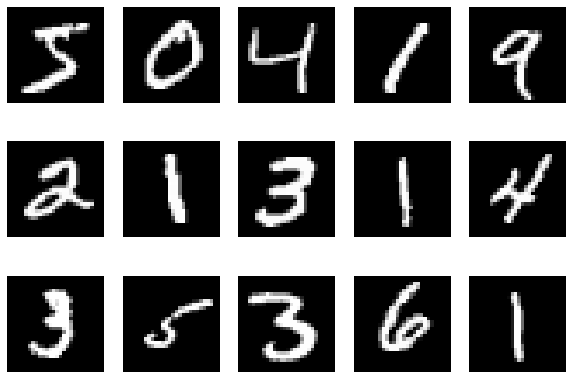

In [7]:
plt.figure(figsize=(10, 7))

for i in range(15):
  plt.subplot(3, 5, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.axis("off")



In [8]:
X_train = X_train.reshape(-1,28, 28, 1).astype("float32")
X_test = X_test.reshape(-1, 28, 28, 1).astype("float32")

X_train /= 255
X_test /= 255

In [9]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# Create Model

In [11]:
model = Sequential()

model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
  
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [13]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train Model

In [14]:
batch_size = 16
epochs = 10

In [15]:
# Save model checkpoints
checkpoint_filepath = "./training_checkpoints/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [16]:
hist = model.fit(X_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 callbacks=[early_stop, model_checkpoint_callback],
                 validation_data=(X_test, y_test))

Epoch 1/10
3750/3750 [==============================] - 25s 6ms/step - loss: 0.1239 - accuracy: 0.9608 - val_loss: 0.0380 - val_accuracy: 0.9882
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.0455 - val_accuracy: 0.9858
Epoch 3/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 0.0451 - val_accuracy: 0.9869
Epoch 4/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0264 - val_accuracy: 0.9914
Epoch 5/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.0354 - val_accuracy: 0.9903
Epoch 6/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0151 - accuracy: 0.9949 - val_loss: 0.0274 - val_accuracy: 0.9924
Epoch 7/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.0387 - val_ac

# Evaluate Model

In [17]:
loss_df = pd.DataFrame(hist.history)
loss_df

,loss,accuracy,val_loss,val_accuracy
0,0.123916,0.960817,0.037956,0.9882
1,0.042053,0.986733,0.045464,0.9858
2,0.029675,0.990683,0.045122,0.9869
3,0.024563,0.991867,0.026444,0.9914
4,0.018751,0.994250,0.035359,0.9903
5,0.015076,0.994950,0.027360,0.9924
6,0.013811,0.995417,0.038703,0.9898
7,0.012402,0.996133,0.050011,0.9875
8,0.012004,0.996117,0.051119,0.9884


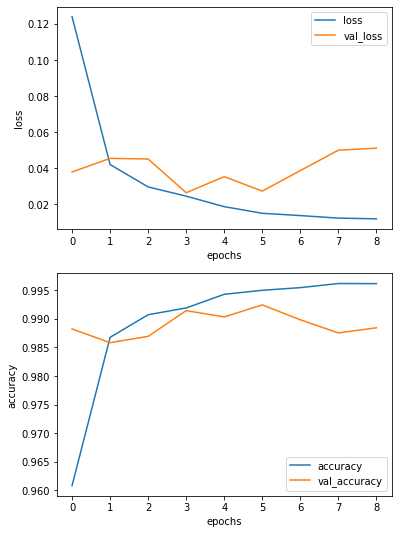

In [18]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(range(len(loss_df)), loss_df["loss"], label="loss")
plt.plot(range(len(loss_df)), loss_df["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(len(loss_df)), loss_df["accuracy"], label="accuracy")
plt.plot(range(len(loss_df)), loss_df["val_accuracy"], label="val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [19]:
# Restore weights
model.load_weights(checkpoint_filepath)

scores = model.evaluate(X_test, y_test)

print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0264 - accuracy: 0.9914
Test Loss: 0.026443764567375183
Test Accuracy: 0.9914000034332275


# Save Model

In [20]:
#model.save("save_models/mnist_model.h5")
loaded_model = load_model("save_models/mnist_model.h5")


# Predictions

In [21]:
new_image = X_test[22].reshape(-1, 28, 28, 1)
y_test[22]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

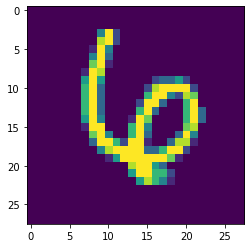

In [22]:
plt.imshow(new_image.reshape(28, 28))

In [23]:
pred = loaded_model.predict(new_image)
pred.argmax()

6